ref: https://www.kaggle.com/code/matthewjansen/nlp-medical-abstract-segmentation 

# Medical Abstract Segmentation (ALL ABSTRACTS)

## Imports

In [ ]:
import re # regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import layers
from keras.utils import plot_model


from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.91 MiB/s, done.


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# For this model we'll use the 20k dataset no preprocessing
dataset_dir = "/content/pubmed-rct/PubMed_20k_RCT/"

## Exploration

free text -> csv

In [ ]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [ ]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [ ]:
train_data[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In summary, this is the outline of an abstract:

* Abstract Start -> ###< abstract_id >\n
* Abstract Line -> < TARGET >\t< abstract_text >
* Abstract End -> \n

## Raw Data Preprocessing

In [ ]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

**Note: we need to do MORE preprocessing to extract abstracts that ONLY specify breast cancer**

In [ ]:
%%time
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

CPU times: user 456 ms, sys: 85.6 ms, total: 542 ms
Wall time: 564 ms


In [ ]:
%%time
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

CPU times: user 89 ms, sys: 8.02 ms, total: 97 ms
Wall time: 97.4 ms


In [ ]:
%%time
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

CPU times: user 73.4 ms, sys: 15.9 ms, total: 89.2 ms
Wall time: 91.6 ms


In [ ]:
train_samples[1] # train_samples is a list of dicts

{'abstract_id': 24293578,
 'line_id': '24293578_1_12',
 'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'line_number': 1,
 'total_lines': 12,
 'current_line': '1_12',
 'target': 'METHODS'}

**Objective, methods, results, etc REMAINS separated**

### To Pandas DF

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS


One method: squish all with same abstract ID

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

## Quick Data Analysis

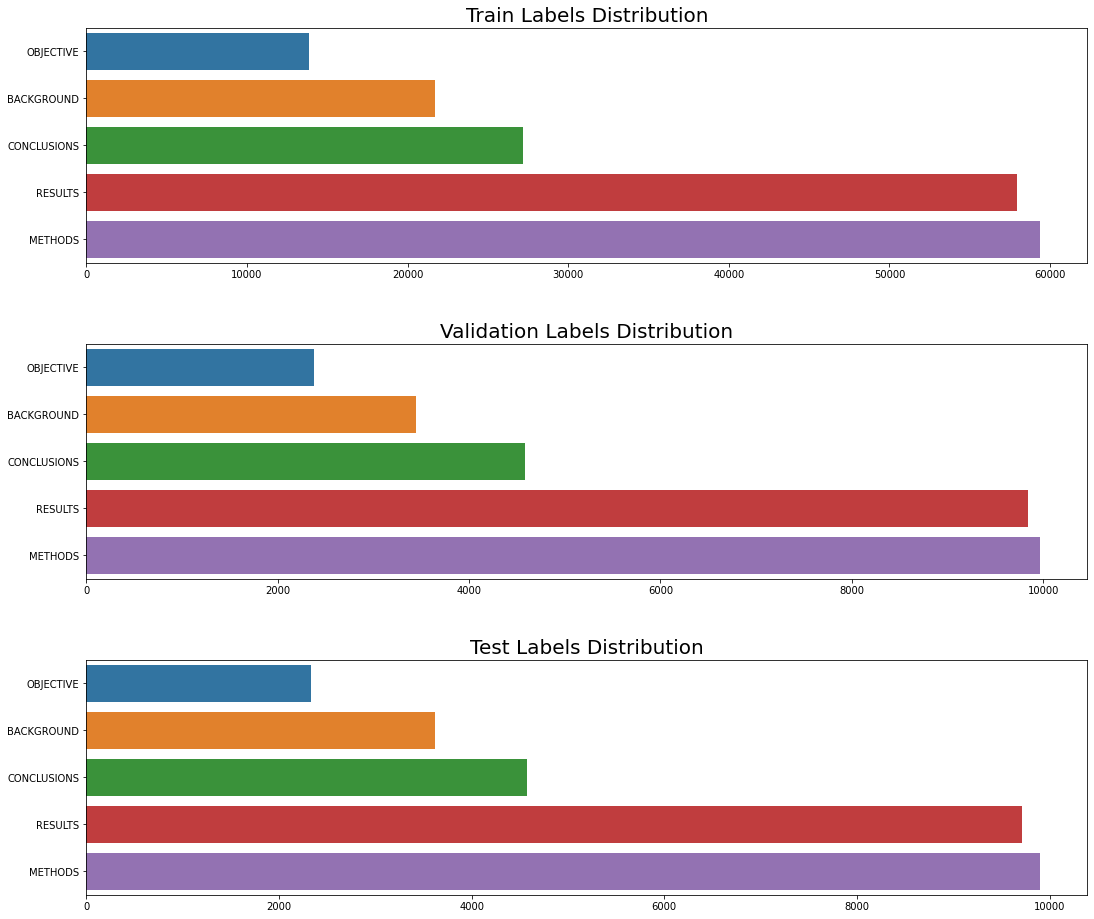

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['target'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['target'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['target'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

# Text Preprocessing

### Sentences as list

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [ ]:
train_sentences[:2]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .']

### One-hot encoding target vars

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [ ]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_df["target"][:2]

0    OBJECTIVE
1      METHODS
Name: target, dtype: object

In [ ]:
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

## Label encode targets

why?

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## One-hot encode "current lines"

In [ ]:
line_one_hot_encoder = OneHotEncoder(sparse_output=False)

In [ ]:
%%time
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

CPU times: user 255 ms, sys: 1.05 s, total: 1.31 s
Wall time: 2.57 s


## Apply smoothing to current_lines 

why?

In [ ]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth
    
    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0
    
    return unsmooth

In [ ]:
# Only apply smoothing to train lines feature 
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [ ]:
train_lines_encoded

array([[0.01, 0.01, 0.99, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]], dtype=float32)

# Dataset input pipeline

In [ ]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.
    
    @params
        - features: (tuple) -> tuple containing the feature data 
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [ ]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [ ]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [ ]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [ ]:
!pip install tensorflow-text

In [ ]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [ ]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

## Model Constructor

In [ ]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [ ]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

In [ ]:
model = build_model()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


In [ ]:
# View summary of model
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 abstract_text_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['abstract_text_input[0][0]']    
 rasLayer)                                                                                        
                                                                                                  
 block_dim_expand (Lambda)      (None, 1, 512)       0           ['universal_sentence_encoder[0][0
                                                                 ]']            

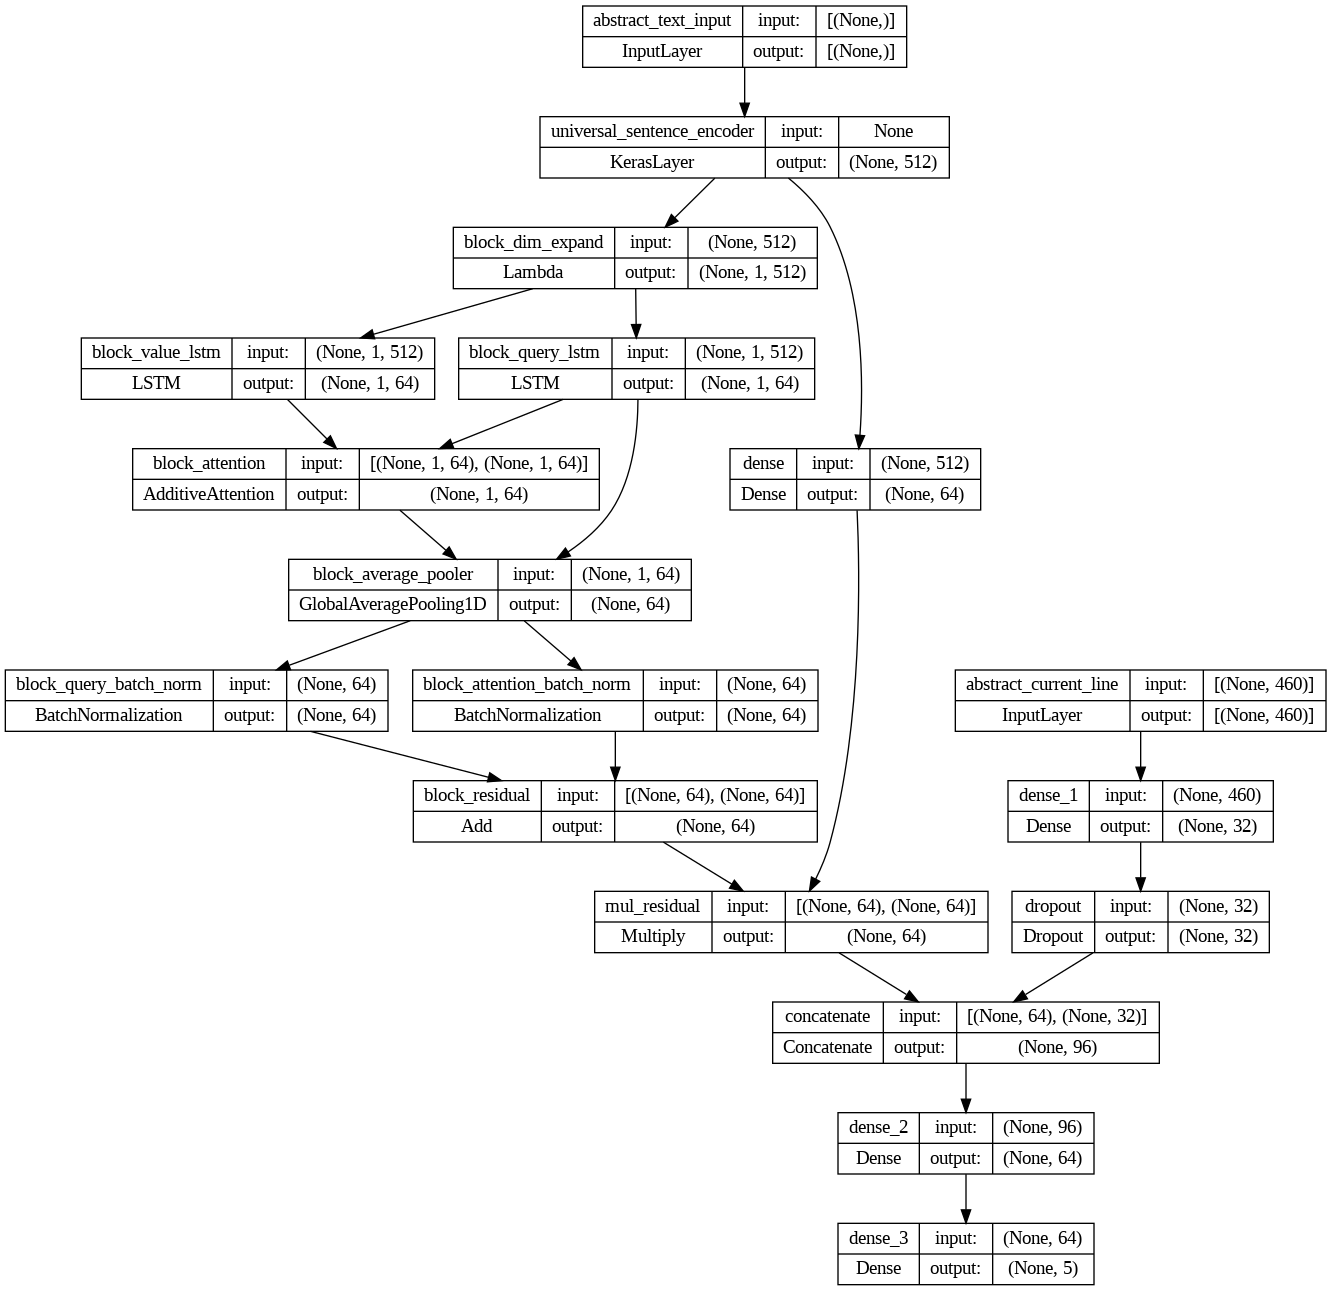

In [ ]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [ ]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

In [ ]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5626/5627 [============================>.] - ETA: 0s - loss: 0.6973 - accuracy: 0.8484

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5627/5627 [==============================] - 156s 26ms/step - loss: 0.6973 - accuracy: 0.8484 - val_loss: 0.6442 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - 143s 25ms/step - loss: 0.6313 - accuracy: 0.8788 - val_loss: 0.6393 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - 140s 25ms/step - loss: 0.6136 - accuracy: 0.8878 - val_loss: 0.6350 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 4/10
5627/5627 [==============================] - 137s 24ms/step - loss: 0.6007 - accuracy: 0.8935 - val_loss: 0.6373 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 5/10
5625/5627 [======

~10 mins

In [ ]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

942/942 [==============================] - 14s 15ms/step - loss: 0.6431 - accuracy: 0.8736


[0.6431058645248413, 0.8736021518707275]

In [ ]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
945/945 [==============================] - 16s 15ms/step


array([[0.7626655 , 0.02842801, 0.01356613, 0.18018784, 0.01515249],
       [0.6726048 , 0.0205406 , 0.01179811, 0.27608112, 0.01897532],
       [0.3232544 , 0.01766315, 0.03885191, 0.59990823, 0.02032232],
       ...,
       [0.01411635, 0.02009557, 0.016047  , 0.01477581, 0.9349652 ],
       [0.04246802, 0.53361523, 0.01378739, 0.0437458 , 0.36638358],
       [0.01572157, 0.96739286, 0.0017624 , 0.01091682, 0.00420633]],
      dtype=float32)

In [ ]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

942/942 [==============================] - 13s 14ms/step


array([[0.44210735, 0.01769067, 0.01228409, 0.51257247, 0.0153453 ],
       [0.28224322, 0.04293977, 0.19558553, 0.36090493, 0.11832642],
       [0.02629275, 0.02415233, 0.81959534, 0.03859002, 0.09136964],
       ...,
       [0.02173413, 0.04755082, 0.02885267, 0.01772483, 0.8841376 ],
       [0.04293182, 0.15415403, 0.02029993, 0.022355  , 0.7602592 ],
       [0.01746117, 0.9551852 , 0.00275757, 0.01467718, 0.00991894]],
      dtype=float32)

In [ ]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [ ]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

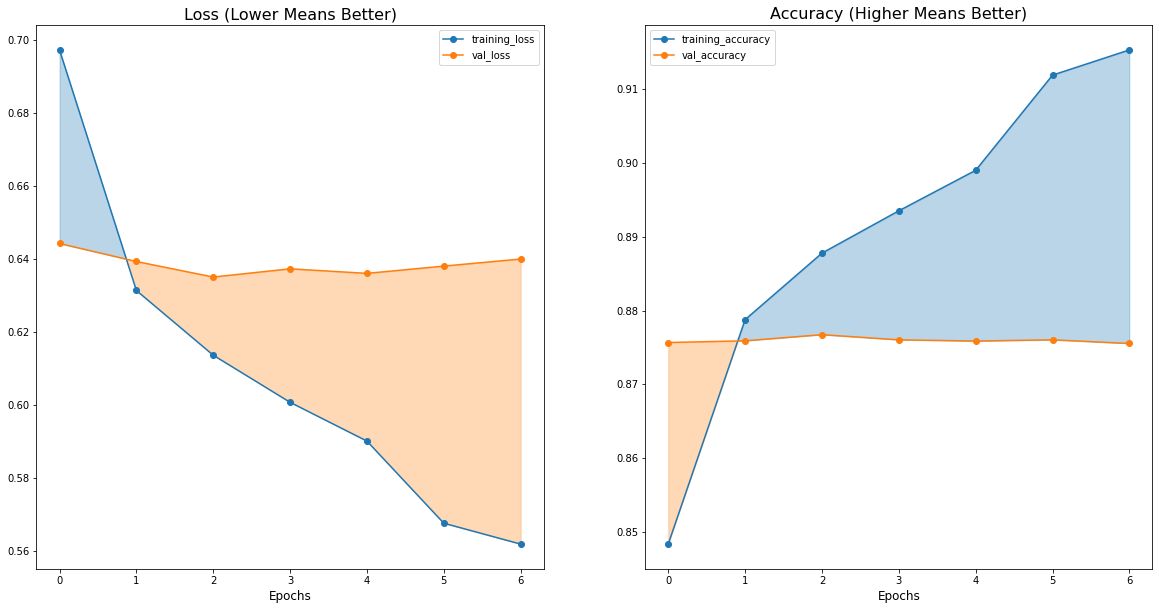

In [ ]:
# plot model training history 
plot_training_curves(model_history)

It seems that the model starts overfitting around the second/third epoch since the train loss curve continues to go lower while the validation loss curve remains somewhat constant. However, since the EarlyStopping callback is implemented the model's best weights are saved after the model's training is stopped.

# Visualizing word embeddings

ref: https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook

In [ ]:
# word2vec visualization

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS


only one sentence?

In [ ]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['abstract_text']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

data = clean_dataframe(train_df)
data.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,investigate efficacy 6 weeks daily lowdose ora...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,total 125 patients primary knee oa randomized ...,1,12,1_12,METHODS
2,24293578,24293578_2_12,outcome measures included pain reduction impro...,2,12,2_12,METHODS
3,24293578,24293578_3_12,pain assessed visual analog pain scale 0100 mm,3,12,3_12,METHODS
4,24293578,24293578_4_12,secondary outcome measures included western on...,4,12,4_12,METHODS


~7mins

In [ ]:
data["abstract_text"][0]

'investigate efficacy 6 weeks daily lowdose oral prednisolone improving pain  mobility  systemic lowgrade inflammation short term effect sustained 12 weeks older adults moderate severe knee osteoarthritis  oa  '

In [ ]:
train_df["abstract_text"][0]

'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'

In [ ]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['abstract_text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]

[['investigate',
  'efficacy',
  '6',
  'weeks',
  'daily',
  'lowdose',
  'oral',
  'prednisolone',
  'improving',
  'pain',
  '',
  'mobility',
  '',
  'systemic',
  'lowgrade',
  'inflammation',
  'short',
  'term',
  'effect',
  'sustained',
  '12',
  'weeks',
  'older',
  'adults',
  'moderate',
  'severe',
  'knee',
  'osteoarthritis',
  '',
  'oa',
  '',
  ''],
 ['total',
  '125',
  'patients',
  'primary',
  'knee',
  'oa',
  'randomized',
  '11',
  '',
  '63',
  'received',
  '75',
  'mgday',
  'prednisolone',
  '62',
  'received',
  'placebo',
  '6',
  'weeks',
  '']]

In [ ]:
model = word2vec.Word2Vec(corpus, window=20, min_count=200, workers=4)
model.wv['cancer']

array([-1.1503555e+00,  1.2157102e+00,  1.0325351e+00,  9.7989273e-01,
        3.4737411e+00,  1.8314319e+00,  1.8475351e+00,  4.6572524e-01,
       -5.9729397e-01, -7.1505725e-01, -1.2655940e+00,  9.0830758e-02,
        1.9915026e+00,  3.2033305e+00,  1.4344572e-02, -2.1779673e-01,
       -1.8134207e+00, -3.3687118e-01,  4.4264569e+00, -2.0113649e+00,
        3.0867164e+00, -2.2913580e+00, -2.1321216e+00,  7.2018820e-01,
       -1.1656303e+00, -1.8839213e+00,  1.7421225e+00, -3.5692008e+00,
       -8.4468365e-01,  1.3228589e+00,  5.6531215e-01, -4.1654485e-01,
       -2.1119506e+00, -1.6706463e+00,  3.1711273e+00, -1.6890557e-02,
        1.7451444e+00,  1.3948447e+00, -3.8770184e-01, -9.9226320e-01,
        1.7400054e+00, -1.0162858e+00, -7.7160329e-01,  4.9608774e+00,
        1.7825052e+00,  9.9667633e-01, -8.9766681e-01, -2.6877373e-01,
        5.5902559e-01, -2.5956249e+00,  5.8074403e-01,  1.6303912e+00,
       -3.4872195e-01,  1.7840358e+00, -2.6310010e+00, -1.9107755e+00,
      

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index: # no longer .vocab
        # tokens.append(model[word])
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

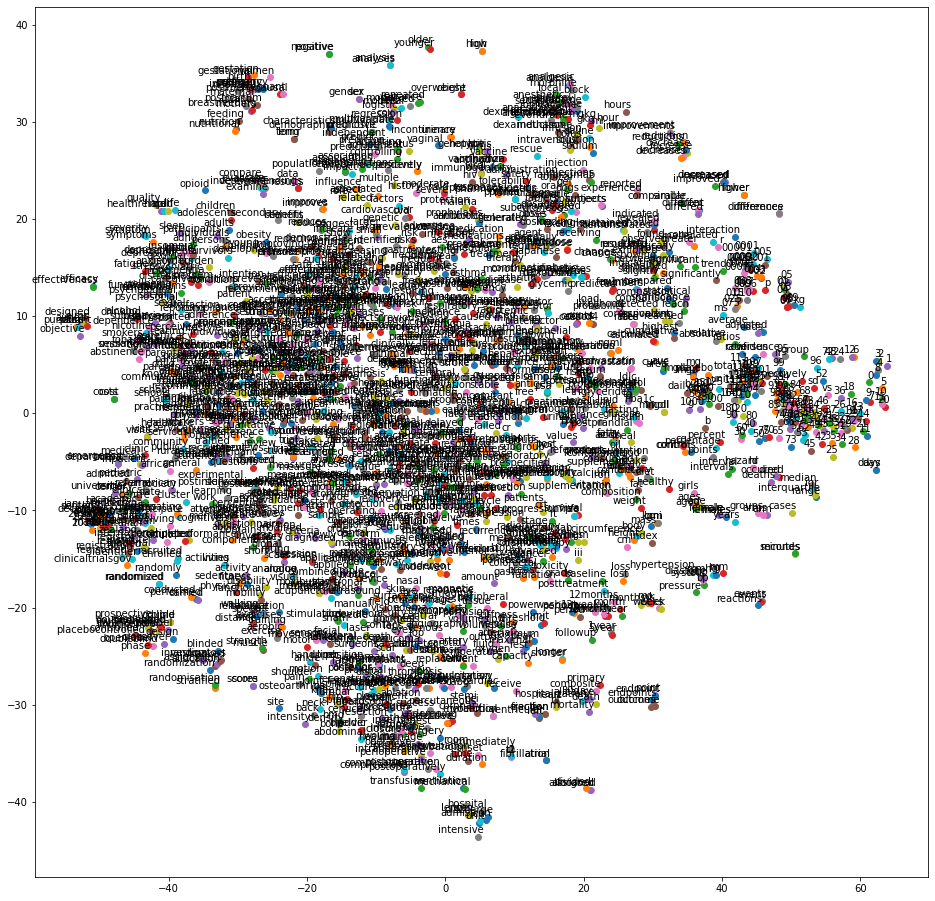

In [ ]:
tsne_plot(model)

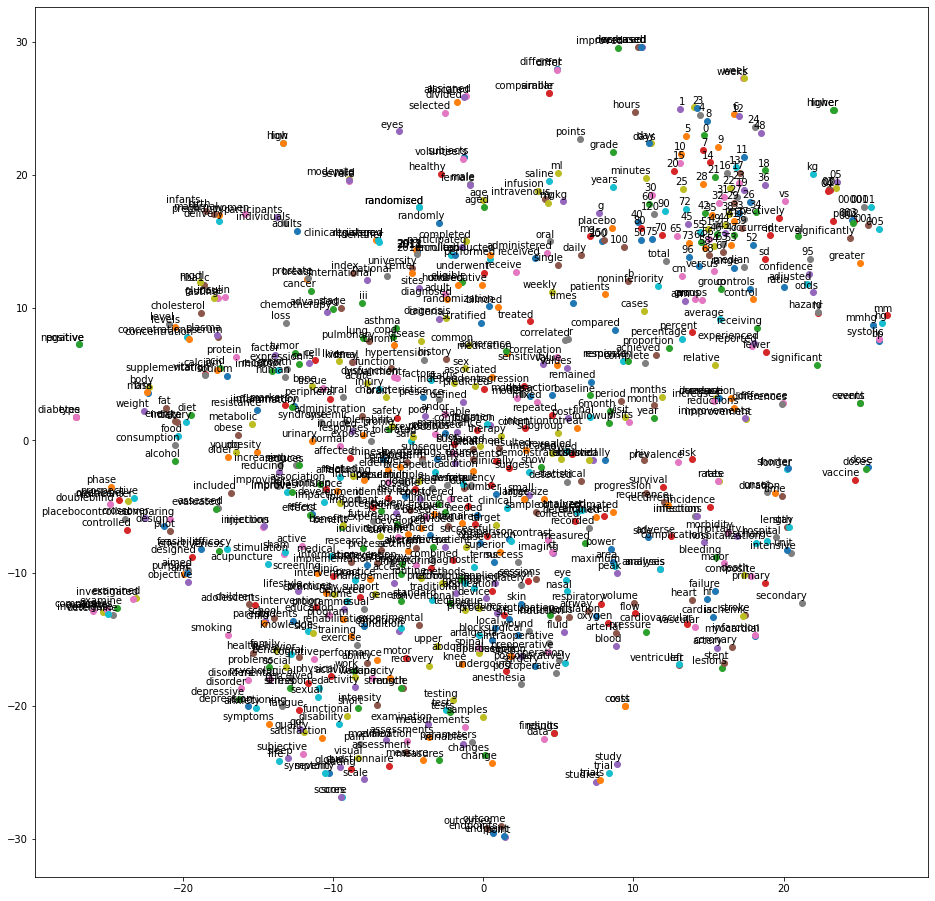

In [ ]:
# more selective
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

## Easier to read

In [ ]:
model.wv.most_similar('cancer')

[('breast', 0.5515053868293762),
 ('prostate', 0.5164119601249695),
 ('advanced', 0.5052737593650818),
 ('chemotherapy', 0.4718486964702606),
 ('screening', 0.43779653310775757),
 ('resection', 0.41108259558677673),
 ('stage', 0.3848419189453125),
 ('diagnosed', 0.3366178572177887),
 ('iii', 0.3214072287082672),
 ('specific', 0.3175327777862549)]

# Pipeline:

**I. Pre-processing**
1. Extract abstracts that mention `breast cancer` only
2.  Data pre-processing 
3. Text pre-processing (Stemming, lemmatization, etc)
4. Text/word embedding (word2vec, GloVe, ELMo, BERT -> they each also have `bio versions` -> potential to try?)
5. Visualize word embeddings and compare

**II. Training**
1. Build model (may not need to do this if we use a pre-trained model)
2. Train/fine-tune the model (optional ^)

**III. Validation**
1. Test the model on the test set
2.  Define accuracy metrics (accuracy, precision, recall, F-1, etc)
3. Plot confusion matrix 